#DCGAN with CIFAR

<p>In this tutorial, we will train a generative adversial network on an image corpus called CIFAR. We will take you step by step into the implementation details.
There is a dedicated library in Tensorflow that provides a ready made trainable GAN, but I believe that it's worth understading before using the package.</p>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import time
import math
import os
#Data
from keras.datasets import cifar10

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Checking tensorflow's version

In [2]:
tf.__version__

'1.9.0'

<b>LOADING DATA</b>
<p>First, we will need to load the data. I picked the cifar data package from Keras.
You can always download it from a link if you prefer not to use this one.
This is a link for a python version from the website of Alex Krizhevsky:
https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz , it also contains specs about the data.<p>
<p> We will not use the classes labels for building our GAN network, as we will label all CIFAR images as 1 later on, considering it's our real data.

In [3]:
def load_data():
    (x_train, y_train), _ = cifar10.load_data()
    # Normalize data so the values are between 0 and 1
    x_train = x_train.astype('float32')/255
    return(x_train, y_train)


def show_image_grid(images, nb_cols):
    nb_images = len(images)
    fig = plt.figure()
    for n,image in enumerate(images):
        a = fig.add_subplot(nb_cols, np.ceil(nb_images/float(nb_cols)), n+1)
        plt.imshow(image)
    fig.set_size_inches(np.array(fig.get_size_inches()) * nb_images/4)
    plt.show()

def test_data(x_train, nb_test_images, nb_cols):
    print('x_train shape:', x_train.shape)
    nb_samples = x_train.shape[0]
    print('Number of training samples: ', nb_samples)
    print('Sample images: \n')
    test_images=[]
    for index in range(nb_test_images):
        test_images.append(x_train[np.random.randint(nb_samples)])
        
    show_image_grid(test_images, nb_cols)

x_train shape: (50000, 32, 32, 3)
Number of training samples:  50000
Sample images: 



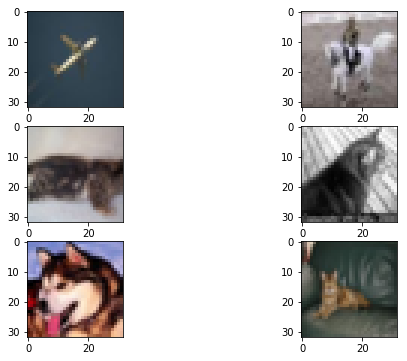

In [4]:
#Test the data and output the sizes
x_train, _ = load_data()
test_data(x_train,6,3)

## <b>Parameters </b>

In [5]:
kernel_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)

<b>The discriminator:</b>
Below is a desciption of the discriminator's architecture following the paper "Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks" ICLR 2016.

In [6]:
def discriminator(input_images, reuse=False, is_training=False, alpha=0.1, dis_out_logits_dim=1024):
    
    with tf.variable_scope('discriminator', reuse= reuse):
        
        # First layer
        layer1 = tf.layers.conv2d(input_images, 
                                  filters=64, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv1')
        layer1 = tf.nn.leaky_relu(layer1, alpha=0.2, name='leaky_relu1')
    
        # Second layer
        layer2 = tf.layers.conv2d(layer1, 
                                  filters=128, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        layer2 = tf.nn.leaky_relu(layer2, alpha=0.2, name='leaky_relu2')

        
        # Third layer
        layer3 = tf.layers.conv2d(layer2, 
                                 filters=256, 
                                 kernel_size=5, 
                                 strides=1,
                                 padding='same',
                                 name='conv3')
        layer3 = tf.layers.batch_normalization(layer3, training=is_training, name='batch_normalization3')
        layer3 = tf.nn.leaky_relu(layer3, alpha=0.1, name='leaky_relu3')
        
        
        #Fourth layer: flatten the output
        layer4 = tf.reshape(layer3, (-1, layer3.shape[1]*layer3.shape[2]*layer3.shape[3]))
        
        
        logits= tf.layers.dense(layer4, 1)
        
        output = tf.sigmoid(logits)
        
        return(output, logits)

<b>The generator network </b>
<p> We start by a noise vector and train the generator to learn producing images similar to the real images. The generator provides images as input to the discriminator, and gets better at every step by tweaking it's parameters using the disciminators loss. The goal of the generator is to lure the discriminator into labelling the generated images as true images. The network architecture follows deconvolution: starts with a vector from the latenet space and ends up with an image, which is the reverse of convolution: start with an image and end up with a vector. </p>

In [7]:
def generator(z, z_dim, batch_size, is_training=False, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        
        # First layer : fully connected connects the input vector z to 8*8*128 units
        input_to_conv = tf.layers.dense(z, 8*8*128)
        layer1 = tf.reshape(input_to_conv, (-1, 8, 8, 128))
        layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='batch_normalization1')
        layer1 = tf.nn.relu(layer1, name='relu1')
        
        # Second layer:
        layer2 = tf.layers.conv2d_transpose(layer1, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        layer2 = tf.nn.relu(layer2, name='relu2')
        
        
        # Third layer
        layer3 = tf.layers.conv2d_transpose(layer2, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution3')
        layer3 = tf.layers.batch_normalization(layer3,training=is_training, name='batch_normalization3')
        layer3 = tf.nn.relu(layer3, name='relu3')
        
        # Third layer
        layer4 = tf.layers.conv2d_transpose(layer3, filters=256, kernel_size=5, strides= 1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution4')
        layer4 = tf.layers.batch_normalization(layer4,training=is_training, name='batch_normalization4')
        layer4 = tf.nn.relu(layer4, name='relu4')
        
        # Third layer
        layer5 = tf.layers.conv2d_transpose(layer4, filters=256, kernel_size=5, strides= 1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution5')
        layer5 = tf.layers.batch_normalization(layer5,training=is_training, name='batch_normalization5')
        layer5 = tf.nn.relu(layer5, name='relu5')
        
        #Fourth layer 
        layer6 = tf.layers.conv2d_transpose(layer5, filters=3, kernel_size=7, strides=1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution6')
        
        
        
        logits = tf.tanh(layer6, name='tanh')
        
        return(logits)

<b>Define Inputs:</b> We create placeholders for the real input and the variable flag for the traning phase.
We also sample the z vector from a truncated normal distribution.

In [8]:
def model_inputs(batch_size, z_dim):
    """
    Define the inputs of the discriminator ang generrator networks.
    
    """
    
    x_train, _ = load_data()
    image_width = x_train.shape[1]
    image_hight = x_train.shape[2]
    image_channels = x_train.shape[3]
    d_input_real = tf.placeholder(tf.float32, shape= (None,image_width, image_hight,image_channels), name="d_input")
    is_training = tf.placeholder(tf.bool, [], name='is_training_bool')
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    # Sample noise from random normal distribution
    z = tf.random_normal([batch_size, z_dim], mean=0.0, stddev=1.0, name='latent_z')
    return(d_input_real, z, is_training, learning_rate)


<b>Define Losses:</b>
Use cross-entropy to calculate loss. The loss for the discriminator is the loss calculated on the real data and the fake data consecutively.
The loss of the generator on the other hand, is the discriminator's loss on the fake data labeled as real.

In [9]:
def model_loss(input_real, input_z, is_training):
    """
    Compute the losses of the generator and the discriminator networks
    while training
    
    """
    
    smooth_label = 0.9
    
    g_out = generator(input_z, z_dim, batch_size, is_training=is_training)
    
    #Feed the real images to the discriminator
    real_d, d_logits_real = discriminator(input_real, reuse=False, is_training=is_training)
    
    #Feed the generated (fake) images to the discriminator
    fake_d, d_logits_fake = discriminator(g_out, reuse=True,  is_training=is_training)
    
    d_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_d) * smooth_label, d_logits_real)
                                                  
    
    d_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fake_d) , d_logits_fake)
    # Summing up discriminator losses
    d_loss = d_loss_real + d_loss_fake
    
    # The loss for the generator the discriminator output on fake data labelled as one.
    g_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(fake_d) * smooth_label, d_logits_fake)

    return(d_loss, g_loss)

<b>Optimization:</b> The variables(wights, biases) of each of the discriminator and the generator networks are optimized seperately. We previously created the networks with a variable scope so it's easy to collect the variables associated withe each network. We also need to collect the operations we defined in each graph that will be used in the training process.
Once we have the variables and the operations to perform on it, we use Adam optimiser to minimize our losses.

<b>On batch normalization:</b> Ioffe and Szegedy proposed a technique to overcome the effects of internal covariate shift, a phenomenon that happens in deep learning, where the distribution of the middle layers changes during training.
So by normalizing the input of these synapses, not only we get a faster convergence, but it also has a regularization effect on the training. The normalization mean and variance are computed on the each mini-batch.

In [10]:
def model_optimizer(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Add the optimization operations to the graph of each network
    
    """
    # Define the discriminator and generator losses.
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, name='discriminator_optimizer')
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, name='generator_optimizer')

    # Get the trainables variables for the discriminator and the generator
    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
    
    # Get the training operations for the discriminator and the generator
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')


    with tf.control_dependencies(d_update_ops):
        d_optimizer = d_optimizer.minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops): 
        g_optimizer = g_optimizer.minimize(g_loss, var_list=g_vars)
    
    return(d_optimizer, g_optimizer)

<b>Sample noise from the generator:</b>


In [11]:
def sample_from_generator(sess, n_images, z_dim):
    """
    Sample output from the generator
    
    """
    
    example_z = tf.random_normal([1, z_dim], mean=0.0, stddev=1.0, name='z_test')
    training_pl = tf.placeholder(tf.bool, [], name='training_bool')                 
    samples = sess.run(   
        generator(example_z, z_dim, batch_size, training_pl,reuse=True),
        feed_dict={training_pl: True})

    plt.imshow((samples[0]))
    plt.show()

<b>Train both networks</b>

In [12]:
def train(epoch_count, batch_size, z_dim, lr):
    """
    Train the generator and the discriminator networks
    
    """
    
    input_real, z, is_training, learning_rate = model_inputs(batch_size, z_dim)
    d_loss, g_loss =  model_loss(input_real, z, is_training)
    d_optimizer, g_optimizer = model_optimizer(d_loss, g_loss, learning_rate, beta1=0.5)
    
    # Data
    x_train, _ = load_data()

    # Parameters
    starting_lr = lr
    batch_size =  batch_size
    latent_dim =  z_dim
    ema_decay = 0.999
    
    nb_batches = int(x_train.shape[0] / batch_size)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            d_train_loss, g_train_loss = 0, 0
            for batch_i in range(nb_batches):
                
                from_index = batch_i * batch_size
                to_index = (batch_i + 1) * batch_size
                
                batch_images = x_train[from_index:to_index]
                
                if(steps % 2 != 0):
                    _, dl = sess.run([d_optimizer,d_loss], feed_dict={input_real: batch_images, is_training:True, learning_rate:lr})
                    d_train_loss += dl
                #run the generator twice as much as the discriminator
                _, gl = sess.run([g_optimizer,g_loss], feed_dict={input_real: batch_images, is_training:True, learning_rate:lr})
                g_train_loss += gl
                
                if(steps % 200 == 0):

                    print("Epoch {}/{}\n".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\n".format(d_train_loss),
                          "Generator Loss: {:.4f}\n".format(g_train_loss))
                
                    _ = sample_from_generator(sess, 1, z_dim)
                    
                steps += 1
   

(?, 1)
(100, 1)
Epoch 1/20
 Discriminator Loss: 0.0000
 Generator Loss: 1.0687



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


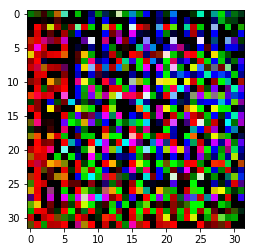

Epoch 1/20
 Discriminator Loss: 149.4156
 Generator Loss: 417.9797



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


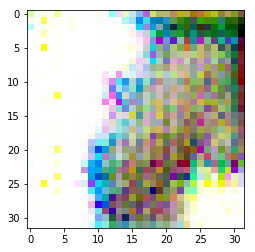

Epoch 1/20
 Discriminator Loss: 293.5545
 Generator Loss: 666.2809



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


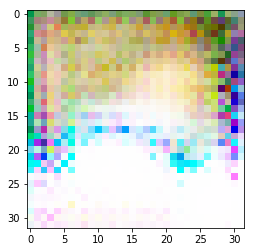

Epoch 2/20
 Discriminator Loss: 73.3824
 Generator Loss: 117.9533



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


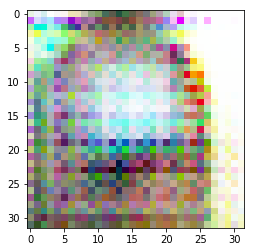

Epoch 2/20
 Discriminator Loss: 220.4793
 Generator Loss: 320.6123



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


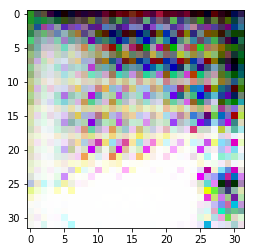

Epoch 3/20
 Discriminator Loss: 0.0000
 Generator Loss: 0.8290



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


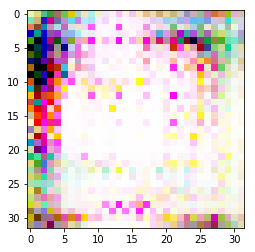

Epoch 3/20
 Discriminator Loss: 148.9847
 Generator Loss: 180.6037



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


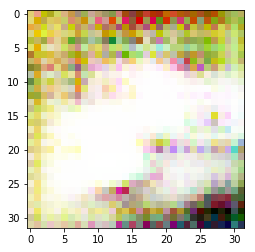

In [ ]:
""" Runs the training process"""
epoch_count = 20
#learning_rate = 0.00002
learning_rate = 0.0002
# Size of mini-batch
batch_size = 100
z_dim = 100

with tf.Graph().as_default():
    train(epoch_count, batch_size, z_dim, learning_rate)